# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.235590,False,-1.927445
1,-0.138515,True,4.699431
2,1.318997,False,0.369026
3,0.400672,True,6.129301
4,-0.725604,False,-0.026105
...,...,...,...
995,-0.251344,True,5.929147
996,1.071573,True,4.935116
997,1.257219,True,4.941646
998,0.224442,False,-0.493632


<AxesSubplot:xlabel='v0'>

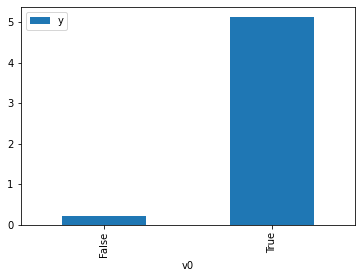

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

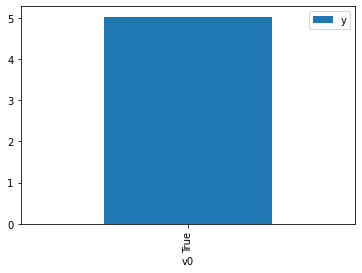

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.385684,False,-0.816065,0.258356,3.870635
1,0.925042,False,1.371057,0.333505,2.998456
2,-0.460712,False,0.477768,0.597993,1.672261
3,1.148797,False,0.580232,0.295610,3.382837
4,1.012931,False,-0.517560,0.318326,3.141430
...,...,...,...,...,...
995,0.636630,False,0.106068,0.385652,2.593009
996,1.174959,False,-0.336483,0.291345,3.432357
997,1.445152,False,3.044493,0.249499,4.008035
998,0.016808,False,1.501700,0.505420,1.978552


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.422091,True,3.209011,0.573698,1.743078
1,-1.821423,True,4.888212,0.187414,5.335786
2,2.328133,True,4.546269,0.857599,1.166046
3,-0.321664,True,2.364813,0.428545,2.333475
4,2.448271,True,7.385566,0.868749,1.151081
...,...,...,...,...,...
995,1.506348,True,6.957432,0.759401,1.316827
996,0.688487,True,5.355686,0.623961,1.602664
997,0.228848,True,6.008927,0.536193,1.865000
998,0.525638,True,4.406645,0.593478,1.684982


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              7970.
Date:                Tue, 16 Aug 2022   Prob (F-statistic):                        0.00
Time:                        13:41:51   Log-Likelihood:                         -1420.3
No. Observations:                1000   AIC:                                      2845.
Df Residuals:                     998   BIC:                                      2854.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1864      0.032      5.825      0.000       0.124       0.249
x2             4.9602      0.051     97.125      0.000       4.860       5.060
==============================================================================
Omnibus:                        2.485   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.289   Jarque-Bera (JB):                2.588
Skew:                          -0.030   Prob(JB):                        0.274
Kurtosis:                       3.242   Cond. No.                         2.36
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""